# Final Assignment for GEOG 863 #

Jason Biagio  |  <jrb430@psu.edu>  |  <jason.biagio@gmail.com>

---
<https://developers.arcgis.com/python/>  |  <https://www.esri.com/en-us/smart-mapping>

---
This notebook is broken into the following steps:
* Import all necessary modules - using ArcGIS API for Python 
* Setup input and output variables
* Import CSV files into single dataframe and filter based on input variables
* Export finalized "filtered" dataframe to a CSV
* Use GeoPandas and Ogr to create a shapefile output of the information contained in the finalized dataframe
* Upload to ESRI's ArcGIS Online a zipped version of the shapefile to be shared and/or displayed using ESRI's arcgis api
* Display final output in webmap widget within this jupyter notebook
* Above and Beyond work...


In [1]:
# import datetime, os, re, sys, zipfile
# from pathlib import Path
import pandas as pd
import numpy as  np
import geopandas as gp
from scipy.spatial import cKDTree
from shapely.geometry import Point

# helper function to use scipy cKDTree spatial index for vectorized searching of nearest points
def nearest(gdf_A, gdf_B):
    nearArrayA = np.array(list(zip(gdf_A.geometry.x, gdf_A.geometry.y)) )
    nearArrayb = np.array(list(zip(gdf_B.geometry.x, gdf_B.geometry.y)) )
    btree = cKDTree(nearArrayb)
    dist, idx = btree.query(nearArrayA, k=1)
    gdf_out = pd.concat(
        [gdf_A, gdf_B.loc[idx, gdf_B.columns != 'geometry'].reset_index(),
         pd.Series(dist, name='dist')], axis=1)
    return gdf_out

from ipywidgets import widgets
from IPython.display import display
# from osgeo import gdal
# from osgeo import ogr
# from osgeo import osr
# import json
import matplotlib.pyplot as plt
# import matplotlib as mpl
# import matplotlib.cm
# import matplotlib.colors
%matplotlib inline

from arcgis.gis import GIS
from arcgis.features import FeatureSet, GeoAccessor, GeoSeriesAccessor
from arcgis.geocoding import geocode, Geocoder, get_geocoders # https://developers.arcgis.com/python/guide/understanding-geocoders/

In [19]:
gis = GIS()
m = gis.map('State College, PA', zoomlevel=13)

geo_addr = 'Beaver Stadium, State College, PA'
geocoded = geocode(geo_addr)[0]
popup = {
    "title" : "Home Address", 
    "content" : geocoded['address']
}
m.draw(geocoded['location'], popup)
m.extent = geocoded['extent']

# create geodataframe from geocoded point results location
# geocoded['location']
geo_gdf = gp.GeoDataFrame([['Geocoded Point', Point(geocoded['location']['x'], geocoded['location']['y'])]], columns=['name','geometry'])

m

MapView(layout=Layout(height='400px', width='100%'), zoom=13.0)

In [3]:
# create geodataframe from Starbucks locations borrowed from Kaggle -> https://www.kaggle.com/starbucks/store-locations
df = pd.read_csv('directory.csv')
gdf = gp.GeoDataFrame(
    df, geometry=[Point(x, y) for x, y in zip(df.Longitude, df.Latitude)])
gdf.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude,geometry
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51,POINT (1.53 42.51)
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42,POINT (55.47 25.42)
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39,POINT (55.47 25.39)
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48,POINT (54.38 24.48)
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51,POINT (54.54 24.51)


In [4]:
sb_out = nearest(geo_gdf,gdf)
sb_out.head()
sb_out_dict = dict()
sb_out_dict = sb_out[['Street Address', 'City', 'State/Province', 'Country', 'Postcode']].iloc[0].to_dict()
content = ', '.join([value for value in sb_out_dict.values()])

In [ ]:
# print(geocoded['extent'])
# extent={}
# extent['xmin'] = sb_out['geometry'].bounds.minx[0]
# extent['ymin'] = sb_out['geometry'].bounds.miny[0]
# extent['xmax'] = sb_out['geometry'].bounds.maxx[0]
# extent['ymax'] = sb_out['geometry'].bounds.maxy[0]
# pt = {}
# pt['x'] = sb_out['geometry'].x[0]
# pt['y'] = sb_out['geometry'].y[0]
# pt['type'] = 'point'
# pt['spatialReference'] = {'wkid': 4326}
# print(extent)

In [20]:
gis = GIS()
m3 = gis.map('State College, PA', zoomlevel=13)

geocoded = geocode(content)[0]
popup = {
    "title" : "Nearest Starbucks", 
    "content" : geocoded['address']
}
geo_addr2 =  geocoded['address']
m3.draw(geocoded['location'], popup)
m3.extent = geocoded['extent']
m3.basemap = 'dark-gray-vector'
m3

MapView(layout=Layout(height='400px', width='100%'), zoom=13.0)

In [ ]:
feature_service_srch_results = gis.content.search(query='title: "Starbucks*" AND type: "Feature Service"')
feature_service_srch_results

feature_service_item = feature_service_srch_results[0]
feature_layer = feature_service_item.layers[0]
feature_layer

sdf = pd.DataFrame.spatial.from_layer(feature_layer)
sdf.head()

sdf.count()

https://developers.arcgis.com/python/guide/performing-route-analyses/

https://community.esri.com/thread/201079-cant-connect-to-portal#

https://developers.arcgis.com/python/sample-notebooks/using-geoprocessing-tools/

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://pennstate.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=6VYnRU6lDUYO5o4d&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········


<Item title:"World Traffic Map" type:Web Map owner:esri>
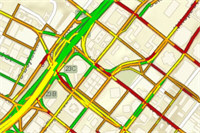

In [6]:
from copy import deepcopy
from datetime import datetime
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding

test_client_id = '6VYnRU6lDUYO5o4d'
my_gis = GIS('https://pennstate.maps.arcgis.com', client_id=test_client_id)
my_gis.users.me

route_service_url = my_gis.properties.helperServices.route.url
route_service_url

route_service = network.RouteLayer(route_service_url, gis=my_gis)
route_service

my_gis.content.search('title: ArcGIS Online Directions and Routing Services Coverage type:Web Map owner:esri',
                      item_type='Web Map', outside_org=True)[0]

my_gis.content.search('title: World Traffic Map type:Web Map owner:esri',
                      item_type='Web Map', outside_org=True)[0]


In [21]:
# stop1_address = '9370 Rd 234, Terra Bella, CA 93270'
# stop2_address = '12 N. Main St., Porterville, CA 93257'

stop1_address = geo_addr
stop2_address = geo_addr2

stop1_geocoded = geocoding.geocode(stop1_address)
stop2_geocoded = geocoding.geocode(stop2_address)

stops = '{0},{1}; {2},{3}'.format(stop1_geocoded[0]['attributes']['X'],
                                  stop1_geocoded[0]['attributes']['Y'],
                                  stop2_geocoded[0]['attributes']['X'],
                                  stop2_geocoded[0]['attributes']['Y'])

route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops=stops, return_directions=False, return_routes=True, 
                           output_lines='esriNAOutputLineNone', return_barriers=False, 
                           return_polygon_barriers=False, return_polyline_barriers=False)

travel_time = result['routes']['features'][0]['attributes']['Total_TravelTime']
print("Total travel time is {0:.2f} min".format(travel_time))

Total travel time is 7.78 min


In [22]:
print(geo_addr)
print(geo_addr2)

Beaver Stadium, State College, PA
30 Hub, University Park, Pennsylvania, 16802


In [23]:
import datetime

start_time = int(datetime.datetime.utcnow().timestamp() * 1000)

route_layer = network.RouteLayer(route_service_url, gis=my_gis)
result = route_layer.solve(stops=stops, 
                           directions_language='en-US', return_routes=False,
                           return_stops=False, return_directions=True,
                           directions_length_units='esriNAUKilometers',
                           return_barriers=False, return_polygon_barriers=False,
                           return_polyline_barriers=False, start_time=start_time,
                           start_time_is_utc=True)

In [24]:
records = []
travel_time, time_counter = 0, 0
distance, distance_counter = 0, 0

for i in result['directions'][0]['features']:
    time_of_day = datetime.datetime.fromtimestamp(i['attributes']['arriveTimeUTC'] / 1000).strftime('%H:%M:%S')
    time_counter = i['attributes']['time']
    distance_counter = i['attributes']['length']
    travel_time += time_counter
    distance += distance_counter
    records.append((time_of_day, i['attributes']['text'], round(travel_time, 2), round(distance, 2))) 

In [25]:
pd.set_option('display.max_colwidth', 100)
df = pd.DataFrame.from_records(records, index=[i for i in range(1, len(records) + 1)], 
                               columns=['Time of day', 'Direction text', 
                                        'Duration (min)', 'Distance (km)'])
HTML(df.to_html(index=False))

Time of day,Direction text,Duration (min),Distance (km)
21:04:53,Start at Location 1,0.00,0.00
21:04:53,Go northeast on Curtin Rd toward Porter Rd,0.36,0.12
21:05:15,Turn left on Porter Rd,0.89,0.46
21:05:46,Turn left on E Park Ave,3.88,2.91
21:08:46,Turn left on N Atherton St (US-322-BR),4.21,3.11
21:09:06,Turn left on Curtin Rd,4.87,3.33
21:09:45,Turn right on N Burrowes St,5.67,3.59
21:10:33,Turn left on Pollock Rd,6.44,3.83
21:11:19,"Finish at Location 2, on the left",6.44,3.83


In [11]:
# td_data = ['<td align="left">{:s}</td> \
#            <td align="left">{:s}</td> \
#            <td align="left">{:.2f}</td> \
#            <td align="left">{:.2f}</td>'.format(*values) 
#            for values in records]
# tr_data = ['<tr>{}</tr>'.format(i) for i in td_data]

# display(HTML('<table> \
#              <tr> <th> Time of day </th> \
#              <th>Instruction</th> \
#              <th>Time</th> \
#              <th>Distance</th> </tr> {0} </table>'.format(''.join(tr_data))))

In [12]:
result

{'messages': [],
 'checksum': 'SJ6ZAUiemQE.',
 'directions': [{'routeId': 1,
   'routeName': 'Location 1 - Location 2',
   'summary': {'totalLength': 0,
    'totalTime': 0,
    'totalDriveTime': 0,
    'envelope': {'xmin': -77.86459574799994,
     'ymin': 40.796274313000026,
     'xmax': -77.86459574799994,
     'ymax': 40.796274313000026,
     'spatialReference': {'wkid': 4326, 'latestWkid': 4326}}},
   'features': [{'attributes': {'length': 0,
      'time': 0,
      'text': 'Start at Location 1',
      'ETA': 1571616026612,
      'arriveTimeUTC': 1571630426612,
      'maneuverType': 'esriDMTDepart'},
     'compressedGeometry': '+q9la6-1vvvvu8+11h0r1d+0+0',
     'strings': [{'string': '12:00 AM',
       'stringType': 'esriDSTEstimatedArrivalTime'},
      {'string': 'Location 1', 'stringType': 'esriDSTStreetName'}]},
    {'attributes': {'length': 0,
      'time': 0,
      'text': 'Finish at Location 2',
      'ETA': 1571616026612,
      'arriveTimeUTC': 1571630426612,
      'maneuverTy

In [26]:
my_map = my_gis.map(zoomlevel=13)

my_map.clear_graphics()
stop_count = result['routes']['features'][0]['attributes']['StopCount']
travel_time = result['routes']['features'][0]['attributes']['Total_TravelTime']
distance = result['routes']['features'][0]['attributes']['Total_Kilometers']

data = [('Number of stops', stop_count),
        ('Total travel time', '{0:.2f} min'.format(travel_time)),
        ('Total travel distance', '{0:.2f} km'.format(distance))]

df = pd.DataFrame.from_records(data)
styles = [    
    dict(selector="td", props=[("padding", "2px")]),
    dict(selector='.row_heading, .blank', props=[('display', 'none;')]),
    dict(selector='.col_heading, .blank', props=[('display', 'none;')])]

symbol = {
    "type": "esriSLS",
    "style": "esriSLSSolid",
    "color": [128,0,128,90],
    "width": 4
}

popup_route = {"title": "Route", 
               "content": df.style.set_table_styles(styles).render()}
popup_stop = {"title": "Stop {}", 
              "content": df.style.set_table_styles(styles).render()}

my_map.draw(result['routes']['features'][0]['geometry'], popup_route, symbol)

for stop in result['stops']['features']:
    address = geocoding.reverse_geocode(stop['geometry'])['address']['Match_addr']
    my_map.draw(stop['geometry'], 
                {"title": "Stop {}".format(stop['attributes']['Sequence']), 
                 "content": address})
my_map.zoom = 12

KeyError: 'routes'

In [ ]:
import arcgis.network as network
route_service = network.RouteLayer(gis.properties.helperServices.route.url, gis=gis)
travel_mode = [i for i in route_service.retrieve_travel_modes()['supportedTravelModes']
    if i['name'] == 'Rural Driving Distance'][0]
routes =  connect_origins_to_destinations(origins_layer=esri_regional,
                                 destinations_layer=dest_layer,
                                 measurement_type=travel_mode,
                                 time_of_day=datetime(1990, 1, 4, 1, 3),
                                 output_name="routes_from_offices_to_hq")

In [ ]:
from arcgis.gis import GIS
import arcgis.geocoding as geocoding
gis = GIS()
callback_map = gis.map('San Diego convention center, San Diego, CA', 16)
def find_addr(callback_map, g):
    try:
        callback_map.draw(g)
        geocoded = geocoding.reverse_geocode(g)
        print(geocoded['address']['Match_addr'])
    except:
        print("Couldn't match address. Try another place...")
callback_map.on_click(find_addr)
callback_map